# Copyright : fast.ai - Jeremy Howard & Sylvain Gugger - 2020 (GPLv3)

Cellules de code et plan du notebook adaptées du livre :

[Deep Learning for Coders with fastai & PyTorch](https://github.com/fastai/fastbook) de Jeremy Howard et Sylvain Gugger.

The code in the original notebooks (and thus the code in this notebook) is covered by the GPL v3 license; see the [LICENSE file](https://github.com/fastai/fastbook/blob/master/LICENSE) for details.

In [1]:
from fastai2.vision.all import *

# Configuration spécifique pour show_image() sur ce dataset : images en niveaux de gris
matplotlib.rc('image', cmap='Greys')

# Les fondamentaux - Entrainer un classifier de chiffres manuscrits

Le jeu de données MNIST : le "Hello World" du deep learning
- [images](https://www.google.com/search?q=mnist+dataset&tbm=isch)
- [historique](https://en.wikipedia.org/wiki/MNIST_database)

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/storage/data/mnist_sample')

## Comment charger une image en mémoire ?

In [3]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/storage/data/mnist_sample/train/3/10.png'),Path('/storage/data/mnist_sample/train/3/10000.png'),Path('/storage/data/mnist_sample/train/3/10011.png'),Path('/storage/data/mnist_sample/train/3/10031.png'),Path('/storage/data/mnist_sample/train/3/10034.png'),Path('/storage/data/mnist_sample/train/3/10042.png'),Path('/storage/data/mnist_sample/train/3/10052.png'),Path('/storage/data/mnist_sample/train/3/1007.png'),Path('/storage/data/mnist_sample/train/3/10074.png'),Path('/storage/data/mnist_sample/train/3/10091.png')...]

In [4]:
im3_path = threes[1]
im3_path

Path('/storage/data/mnist_sample/train/3/10000.png')

In [5]:
im3 = Image.open(im3_path)
type(im3)

PIL.PngImagePlugin.PngImageFile

In [6]:
im3

In [7]:
im3_t = tensor(im3)
type(im3_t), im3_t.shape

(torch.Tensor, torch.Size([28, 28]))

In [8]:
im3_t[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

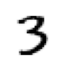

In [9]:
show_image(im3_t)

In [10]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [11]:
type(three_tensors),type(three_tensors[0])

(list, torch.Tensor)

## Comment stocker tous les exemples dans un tableau ?

In [12]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [13]:
stacked_threes[1,4:10,4:10]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1137],
        [0.0000, 0.0000, 0.0000, 0.1882, 0.6510, 0.8784],
        [0.0000, 0.3647, 0.9569, 0.9765, 0.9922, 0.7333],
        [0.0000, 0.4196, 0.9922, 0.9922, 0.9020, 0.1882],
        [0.0000, 0.0118, 0.0784, 0.0784, 0.0588, 0.0000]])

In [14]:
stacked_digits = torch.cat([stacked_threes, stacked_sevens])
stacked_digits.shape

torch.Size([12396, 28, 28])

In [15]:
train_x = stacked_digits.view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [16]:
stacked_labels = tensor([1]*len(threes) + [0]*len(sevens))
stacked_labels.shape

torch.Size([12396])

In [17]:
train_y = stacked_labels.unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

## Comment effectuer des calculs sur un ensemble d'exemples ?

**Element-wise operations**

In [18]:
mean3 = stacked_threes.mean(0)
mean3.shape

torch.Size([28, 28])

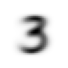

In [19]:
show_image(mean3);

**Broadcasting**

In [20]:
diff_3_abs = (stacked_threes - mean3).abs()
diff_3_abs.shape

torch.Size([6131, 28, 28])

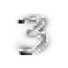

In [21]:
show_image(diff_3_abs[1])

In [22]:
dist_3_abs = diff_3_abs.mean((-1,-2))
dist_3_abs.shape

torch.Size([6131])

**Règles du broadcasting** dans numpy et PyTorch :
1. Si les tableaux n'ont pas le même rang, préfixer la forme du tableau de rang inférieur avec des 1 jusqu'à ce que les deux formes aient la même longueur.
2. Les deux tableaux sont compatibles dans une dimension :
   - s'ils ont la même taille dans la dimension
   - ou si l'un des tableaux a la taille 1 dans cette dimension.
3. Chaque tableau se comporte comme s'il avait une forme égale au maximum des formes des deux tableaux d'entrée. Dans toute dimension où un tableau a une taille de 1 et l'autre tableau a une taille supérieure à 1, le premier tableau se comporte comme s'il était copié dans cette dimension.

## Quel modèle pour reconnaitre des images de chiffres ?

In [23]:
class LinearModel:    
    
    @staticmethod
    def init_params(size): 
        return torch.randn(size).requires_grad_()
    
    def __init__(self):
        self.params = (LinearModel.init_params(28*28), LinearModel.init_params(1))
            
    def __call__(self, inputs):
        weights,bias = self.params
        return inputs@weights + bias
    
    def predict(self, inputs):
        activations = self(inputs)
        return activations > 0

In [24]:
model = LinearModel()

In [25]:
activations = model(train_x)
activations[:8]

tensor([-12.4802, -19.7547, -15.9142, -21.6154, -16.7686, -12.7532, -19.1668,
         -0.4844], grad_fn=<SliceBackward>)

In [26]:
predictions = model.predict(train_x)
predictions[:8]

tensor([False, False, False, False, False, False, False, False])

## Comment mesurer l'erreur de prédiction ?

**Métrique de performance (metrics)** - pour le data scientist

In [27]:
corrects = (predictions == stacked_labels)
corrects[:8]

tensor([False, False, False, False, False, False, False, False])

In [28]:
corrects[:8].float()

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
corrects[:8].float().mean()

tensor(0.)

In [30]:
def accuracy(activations, targets):
    predictions = activations > 0
    corrects = (predictions == targets)
    return corrects.float().mean()

In [31]:
accuracy(activations, stacked_labels)

tensor(0.4404)

**Fonction de coût (loss function)** - pour le processus d'ajustement des paramètres

In [32]:
activations_01 = torch.sigmoid(activations)
activations_01[:8]

tensor([3.8012e-06, 2.6342e-09, 1.2262e-07, 4.0976e-10, 5.2177e-08, 2.8930e-06,
        4.7422e-09, 3.8121e-01], grad_fn=<SliceBackward>)

In [33]:
distances = torch.where(stacked_labels==1, 
                        1 - activations_01, 
                        activations_01 - 0 )
distances[:8]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6188],
       grad_fn=<SliceBackward>)

In [34]:
def mnist_loss(activations, targets):
    activations_01 = activations.sigmoid()
    distances = torch.where(targets==1, 
                            1 - activations_01, 
                            activations_01)
    return distances.mean()

In [35]:
mnist_loss(activations, stacked_labels)

tensor(0.5618, grad_fn=<MeanBackward0>)

## Comment anticiper la variation de l'erreur ?

**Approche expérimentale (coût de calcul +++)**

In [36]:
model = LinearModel()

initial_weights = model.params[0]
initial_bias = model.params[1]
loss = mnist_loss(model(train_x), stacked_labels)

weights0 = initial_weights.clone(); weights0[142] += 0.1
model.params = (weights0, initial_bias)
loss0 = mnist_loss(model(train_x), stacked_labels)
loss_var_when_p0_changes = (loss0 - loss)/0.1

weights1 = initial_weights.clone(); weights1[143] += 0.1
model.params = (weights1, initial_bias)
loss1 = mnist_loss(model(train_x), stacked_labels)
loss_var_when_p1_changes = (loss1 - loss)/0.1

weights2 = initial_weights.clone(); weights2[144] += 0.1
model.params = (weights2, initial_bias)
loss2 = mnist_loss(model(train_x), stacked_labels)
loss_var_when_p2_changes = (loss2 - loss)/0.1

# ... à faire pour chaque paramètre, soit 785 fois ...

model.params = (initial_weights, initial_bias)

[loss_var_when_p0_changes, loss_var_when_p1_changes, loss_var_when_p2_changes]

[tensor(0., grad_fn=<DivBackward0>),
 tensor(-6.9141e-05, grad_fn=<DivBackward0>),
 tensor(-0.0002, grad_fn=<DivBackward0>)]

**Calcul automatique du gradient par PyTorch**

In [37]:
loss = mnist_loss(model(train_x), stacked_labels)

loss.backward()

gradient = model.params[0].grad
gradient.shape

torch.Size([784])

In [38]:
gradient[[142,143,144]]

tensor([-9.6849e-07, -6.9855e-05, -2.4215e-04])

La mesure de l'erreur de prédiction par rapport aux résultats attendus est le signal qui permet de calculer un gradient puis de faire un pas dans la bonne direction pour améliorer les paramètres.

Si on mesure cette erreur seulement sur deux ou trois exemples d'entrainement, on risque de faire un pas d'ajustement qui diminue l'erreur sur ces deux ou trois exemples particuliers, mais qui augmente l'erreur globalement sur tous les autres exemples.

Si on mesure cette erreur sur l'ensemble des exemples d'entrainement, on ne peut faire qu'un seul pas d'ajustement à chaque passage sur la totalité des données d'entrainement : l'entrainement va converger très lentement et durer un temps infini, on gâche beaucoup de capacités de calcul.

En pratique, on trouve un compromis en calculant l'erreur sur les données paquet par paquet (**mini-batchs** de données) :
- on choisit une **taille de batch** (le nombre d'exemples examinés à chaque itération) suffisamment grande pour que la mesure de l'erreur donne une bonne approximation du gradient sur l'ensemble du jeu d'entrainement
- on choisit une taille de batch suffisamment petite pour pouvoir appliquer un pas d'amélioration des paramètres du modèle aussi souvent que possible, réduire le temps de calul à chaque itération, pour accélérer la convergence du processus

De plus, les cartes graphiques (GPUs) sont optimisés pour réaliser les mêmes opérations simultanément sur un batch de données similaires. 

Concrètement, on sélectionne en général la taille des mini-batchs en **fonction de la capacité mémoire du GPU**, pour tirer le maximum des capacités de calcul du matériel. 

## Comment parcourir le jeu de données par mini-batch ?

**Dataset : couples (input,label)**

In [39]:
train_dataset = list(zip(train_x,train_y))
len(train_dataset)

12396

In [40]:
first_item = train_dataset[0]
type(first_item), first_item[0].shape, first_item[1]

(tuple, torch.Size([784]), tensor([1]))

**DataLoader : mini-batchs (inputs,labels)**

La **classe fastai2 Dataloader** a pour mission de créer des batches de données à partir d'un flux d'exemples fournis par une Datasource.

Pour apporter plus de variété à chaque époque et éviter une source potentielle de sur-spécialisation si on présentait de manière répétée toujours les mêmes batches dans la boucle d'apprentissage, on re-mélange les exemples de données de manière aléatoire en début de chaque époque avant de constituer des batchs.

In [41]:
train_dl = DataLoader(train_dataset, batch_size=256)
type(train_dl)

fastai2.data.load.DataLoader

In [42]:
first_batch = train_dl.one_batch()
type(first_batch), first_batch[0].shape, first_batch[1].shape

(tuple, torch.Size([256, 784]), torch.Size([256, 1]))

On réalise la même mise en forme sur le **jeu de données de validation** :

In [43]:
# Chemins de fichiers
threes_valid = (path/'valid'/'3').ls().sorted()
sevens_valid = (path/'valid'/'7').ls().sorted()
# Liste de tensors
three_tensors_valid = [tensor(Image.open(o)) for o in threes_valid]
seven_tensors_valid = [tensor(Image.open(o)) for o in sevens_valid]
# Tableaux uniques - images
stacked_threes_valid = torch.stack(three_tensors_valid).float()/255
stacked_sevens_valid = torch.stack(seven_tensors_valid).float()/255
valid_x = torch.cat([stacked_threes_valid, stacked_sevens_valid]).view(-1, 28*28)
# Tableaux uniques - labels
stacked_labels_valid = tensor([1]*len(threes_valid) + [0]*len(sevens_valid))
valid_y = stacked_labels_valid.unsqueeze(1)
# Dataset
valid_dataset = list(zip(valid_x,valid_y))
# Dataloader
valid_dl = DataLoader(valid_dataset, batch_size=256)

## Comment réaliser une boucle d’apprentissage ?

1. Création de deux DataLoaders pour les jeux d'entrainement et de validation

La **classe fastai2 Dataloaders** permet de regrouper les Dataloader des jeu de données d'entrainement et de validation :

In [44]:
dls = DataLoaders(train_dl,valid_dl)
len(dls.train),len(dls.valid)

(49, 8)

2. Choix d'un modèle de prédiction avec des paramètres ajustables

In [45]:
class LinearModel:    
    
    @staticmethod
    def init_params(size): 
        return torch.randn(size).requires_grad_()
    
    def __init__(self):
        self.params = (LinearModel.init_params(28*28), LinearModel.init_params(1))
            
    def __call__(self, inputs):
        weights,bias = self.params
        return inputs@weights + bias
    
    def predict(self, inputs):
        activations = self(inputs)
        return activations > 0

3. Définition de fonctions de mesure de l'erreur de prédiction : loss function et métrique(s)

In [46]:
def accuracy(activations, targets):
    predictions = activations > 0
    corrects = (predictions == targets)
    return corrects.float().mean()

In [47]:
def mnist_loss(activations, targets):
    activations_01 = activations.sigmoid()
    distances = torch.where(targets==1, 
                            1 - activations_01, 
                            activations_01)
    return distances.mean()

4. Anticipation de l'évolution de l'erreur pour un petit ajustement des paramètres

In [48]:
def compute_gradient(xb, yb, model, loss_func):
    activations = model(xb)
    loss = loss_func(activations, yb)
    loss.backward()

5. Ajustement des paramètres sur un mini-batch de données

In [49]:
class SGDOptimizer:
    
    def __init__(self, model, lr):
        self.params = list(model.params)
        self.lr = lr
    
    def adjust_params(self):
        for param_tensor in self.params:
            param_tensor.data -= self.lr * param_tensor.grad
            
    def zero_grad(self):
        for param_tensor in self.params:
            param_tensor.grad.zero_()

6. Entrainement sur une époque

In [50]:
def train_epoch(train_dl, model, loss_func, optim):
    for xb,yb in train_dl:
        compute_gradient(xb, yb, model, loss_func)
        optim.adjust_params()
        optim.zero_grad()

7. Calcul des métriques de performances sur le jeu de données de validation

In [51]:
def validate_epoch(valid_dl, model, metric):
    perfs = [compute_metric(xb, yb, model, metric) for xb,yb in valid_dl]
    return round(torch.stack(perfs).mean().item(), 4)

def compute_metric(xb, yb, model, metric):
    activations = model(xb)
    return metric(activations, yb)

8. Entrainement du modèle

In [52]:
def train_model(dls, model, loss_func, metric, optim, epochs):
    for i in range(epochs):
        train_epoch(dls.train, model, loss_func, optim)
        print(validate_epoch(dls.valid, model, metric), end=' ')

9. Exécution de l'entrainement

In [53]:
model = LinearModel()
sgd = SGDOptimizer(model, lr=1.)

train_model(dls, model, loss_func=mnist_loss, metric=accuracy, optim=sgd, epochs=40)

0.5818 0.6699 0.8556 0.901 0.9158 0.9289 0.9366 0.9414 0.9456 0.9488 0.9522 0.9526 0.9541 0.9555 0.9579 0.9584 0.9584 0.9598 0.9598 0.9598 0.9598 0.9598 0.9598 0.9603 0.9608 0.9613 0.9618 0.9623 0.9623 0.9623 0.9628 0.9628 0.9633 0.9633 0.9633 0.9637 0.9637 0.9642 0.9642 0.9642 

## Utiliser les classes de PyTorch et fastai2

Le module PyTorch **nn.Linear** est l'équivalent de notre classe LinearModel :

In [54]:
model = nn.Linear(28*28,1)

L'optimiseur PyTorch **SGD** est l'équivalent de notre classe SGDOptimizer :

In [55]:
optim = SGD(model.parameters(), lr=1.0)

La classe fastai2 **Learner** permet de regrouper :
- les jeux de données d'entrainement et de validation
- le modèle et ses paramètres
- l'optimiseur : opt_func
- la fonction de mesure de l'erreur pour calculer le gradient : loss_func
- les indicateurs de performance qui intéressent le data scientist : metrics

In [56]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=accuracy)

Sa **méthode fit(epochs, learning_rate)** est l'équivalent de notre fonction train_model :

In [57]:
learn.fit(10, lr=1.)

epoch,train_loss,valid_loss,accuracy,time
0,0.637205,0.503283,0.495584,00:00
1,0.457336,0.242558,0.783611,00:00
2,0.170577,0.165788,0.851325,00:00
3,0.076077,0.100480,0.916585,00:00
4,0.041172,0.074437,0.935721,00:00
5,0.027486,0.060148,0.949460,00:00
6,0.021829,0.051182,0.957802,00:00
7,0.019288,0.045181,0.964671,00:00
8,0.017983,0.040943,0.966634,00:00
9,0.017190,0.037806,0.968106,00:00


On retrouve une performance de classification finale de l'ordre de 97%.

Pour aller plus loin, on peut remplacer notre modèle linéaire par un modèle un tout petit peu plus compliqué : des combinaisons de segments au lieu de simples droites. 

On définit ainsi un réseau de neurones.

## Création d'un réseau de neurones à un niveau

Un niveau de **réseau de neurone** (feed-forward ou fully-connected) se traduit par l'enchainement des 3 modules suivants :
- production de 30 combinaisons linéaires différentes des 28*28 paramètres d'entrée (23 550 paramètres à ajuster)
- ajout d'une non linéarité (création de "segments de droite" à combiner)
- combinaisation linéaire des 30 valeurs intermédiaires pour produire une prédiction (31 paramètres à ajuster)

In [58]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

Essayons d'entrainer ce nouveau modèle de la même manière :
- le précédent modèle avait 785 paramètres à ajuster
- le nouveau modèle a 23 581 paramètres à ajuster (30x plus de capacité de calcul)

In [59]:
learn = Learner(dls, simple_net, opt_func=SGD,
               loss_func=mnist_loss, metrics=accuracy,
               cbs=ShowGraphCallback())

epoch,train_loss,valid_loss,accuracy,time
0,0.325570,0.414131,0.504416,00:00
1,0.150404,0.235296,0.798332,00:00
2,0.083032,0.117925,0.911187,00:00
3,0.054418,0.079414,0.939156,00:00
4,0.041190,0.061997,0.954858,00:00
5,0.034450,0.052262,0.962709,00:00
6,0.030584,0.046127,0.965162,00:00
7,0.028070,0.041927,0.965653,00:00
8,0.026258,0.038865,0.967615,00:00
9,0.024854,0.036519,0.968106,00:00


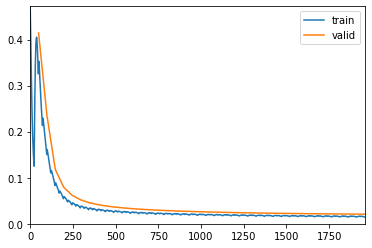

In [60]:
learn.fit(40, 0.1)

Nouvelle tentative avec un réseau de neurones à 18 niveaux : **retour aux 3 lignes de code de la précédente session**
- le précédent modèle avait 23 581 paramètres à ajuster
- le nouveau modèle a 11.7 millions de paramètres à ajuster (500x plus de capacité de calcul)
- et le nouveau modèle a une architecture beaucoup mieux adaptée au problème
- l'étude de cette architecture sera l'objet d'une prochaine session

In [3]:
from fastai2.metrics import accuracy

In [4]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.145013,0.027571,0.993621,00:11


On atteint un taux de succès de classification de **99.7%** en 10 secondes.

In [5]:
# nombre de paramètres du modèle
np.sum([layerparams.data.numel() for layerparams in learn.model.parameters()])

11704896